In [1]:
# Set up
%pylab inline
# Libraries
import os
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import scipy.stats
import seaborn.apionly as sns
#
REGDIR = "/storage/szfeupe/Runs/650GTEx_estr/Analysis_by_Tissue/Lung/QuadraticReg/"

Populating the interactive namespace from numpy and matplotlib


In [ ]:
#Control for alpha and beta pvalues  && R-squares in the quad
regress = regress.loc[(regress['alpha.pval'].astype(float)<0.1)|(regress['beta.pval'].astype(float)<0.1)]
regress = regress.loc[(regress['quad_rsq'].astype(float)>0.2)]#|(regress['beta.pval'].astype(float)<0.05)]
#----
regress["delta_aic[Lin-Quad]"] = regress["delta_aic[Lin-Quad]"].astype(float)
regress = regress.replace([np.inf], np.nan)
regress['ID'] = regress['gene']+regress['str.id']
permuted0['ID'] = permuted0['gene']+permuted0['str.id']
permuted = permuted0.loc[permuted0['ID'].isin(list(regress['ID']))].copy()
permuted = permuted.loc[permuted["delta_aic[Lin-Quad]"]!='None']
permuted["delta_aic[Lin-Quad]"] = permuted["delta_aic[Lin-Quad]"].astype(float)
permuted = permuted.replace([np.inf], np.nan)

print(regress.shape, len(L), max(L), min(L))

In [6]:
regress = pd.read_csv(os.path.join(REGDIR, "quadratic_reg_out.table"), sep="\t")
permuted0 = pd.read_csv(os.path.join(REGDIR,"quadratic_reg_out_perm.table"), sep="\t")
print(regress.shape, permuted0.shape)
regress['ID'] = regress['gene']+regress['str.id']
permuted0['ID'] = permuted0['gene']+permuted0['str.id']
regress = regress.loc[(regress["delta_aic[Lin-Quad]"]!='None')]
permuted = permuted0.loc[permuted0['ID'].isin(list(regress['ID']))].copy()
L=list(regress["delta_aic[Lin-Quad]"])

(94386, 18) (94386, 18)


In [7]:
bin_values = np.arange(start=min(L), stop=max(L), step=50)
permuted["delta_aic[Lin-Quad]"].plot(kind='hist', bins=bin_values, figsize=[12,5], alpha=.3, legend=True, label='Permuted', color='red')
regress["delta_aic[Lin-Quad]"].plot(kind='hist', bins=bin_values, figsize=[12,5], alpha=.2, legend=True, label='Observed', color='blue')
plt.xticks(np.arange(-3000, 18000, 1000), rotation=60)
plt.grid(color='lightgrey', linestyle='--')
plt.title("Delta AIC distriution [Lin-Quad] \n 'Guadratic regression test'")
plt.show()

TypeError: unsupported operand type(s) for -: 'str' and 'str'

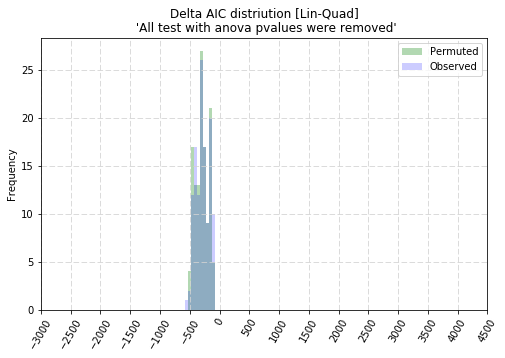

(127, 19)

In [4]:
#When we remove null pvalues
N = regress.shape[0]
regress = regress.loc[regress['anova_pva'].astype(float)>0]
permuted = permuted.loc[permuted['anova_pva'].astype(float)>0]
L=list(regress["delta_aic[Lin-Quad]"])
bin_values = np.arange(start=min(L), stop=max(L), step=50)

permuted["delta_aic[Lin-Quad]"].plot(kind='hist', bins=bin_values, figsize=[8,5], alpha=.3, legend=True, label='Permuted', color='green')
regress["delta_aic[Lin-Quad]"].plot(kind='hist', bins=bin_values, figsize=[8,5], alpha=.2, legend=True, label='Observed', color='blue')
plt.xticks(np.arange(-3000, 5000, 500), rotation=60)
plt.grid(color='lightgrey', linestyle='--')
plt.title("Delta AIC distriution [Lin-Quad]\n 'All test with anova pvalues were removed'")
plt.show()
regress.shape

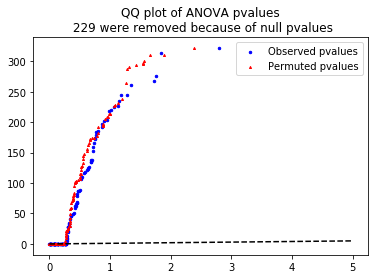

In [22]:
#X = [x for x in range(len(L))]
unif = sorted(list(np.random.uniform(low=0, high=1, size=len(L))))
unif_log = [-1*np.log10(x) for x in unif]
pvals = sorted(list(regress["anova_pva"].astype(float)))
pvals_log = [-1*np.log10(x) for x in pvals]
plt.scatter(unif_log, pvals_log, color='blue', label="Observed pvalues", s=6, marker='o')

L=list(permuted["delta_aic[Lin-Quad]"])
pvalsp = sorted(list(permuted["anova_pva"].astype(float)))
pvalsp_log = [-1*np.log10(x) for x in pvalsp]
unif = sorted(list(np.random.uniform(low=0, high=1, size=len(L))))
unif_log = [-1*np.log10(x) for x in unif]

plt.plot([0,5],[0,5], color="black", linestyle='--')
plt.scatter(unif_log, pvalsp_log, color='red', label="Permuted pvalues", s=4, marker='^')
plt.title("QQ plot of ANOVA pvalues\n "+str(N-regress.shape[0])+" were removed because of null pvalues")
plt.legend()
plt.show()

In [32]:
Goodexamples = regress.loc[(regress['linear.pval']>0.1)&(regress["delta_aic[Lin-Quad]"]>0)]
#46
def ExtractData(gene, chrom, start, tissue):
    """By MG"""
    if "(" in tissue: tissue = tissue.split("(")[0]
    vcf = "/storage/szfeupe/Runs/650GTEx_estr/Merged_STRs_all_samples.vcf.gz"
    # Pull out STR genotypes
    cmd = """bcftools query -r %s:%s-%s -f"[%%SAMPLE\\t%%GB\\n]" %s | \
    grep -v "\." | sed 's/|/\\t/' | awk '{print $1 "\\t" $2+$3}' > str_genotypes.tab"""%(chrom, start, start, vcf)
    os.system(cmd)
    # Pull out STR genotypes - alleles
    cmd = """bcftools query -r %s:%s-%s -f"[%%SAMPLE\\t%%GB\\n]" %s | \
    grep -v "\." | sed 's/|/\\t/' | awk '{print $1 "\\t" $2","$3}' > str_genotypes_alleles.tab"""%(chrom, start, start, vcf)
    os.system(cmd)
    # Pull out gene expression
    expr="/storage/szfeupe/Runs/650GTEx_estr/Analysis_by_Tissue/%s/Corr_Expr.csv"%tissue
    colnum = open(expr,"r").readline().split(",").index('"' + gene + '"')+2
    cmd = """cat %s | cut -d',' -f 1,%s | grep -v ENSG > expr.tab"""%(expr, colnum)
    os.system(cmd)
    
        
def PlotESTR(gene, tissue, chrom, start, COLORS, name, motif):
    strgt = pd.read_csv("str_genotypes.tab", sep="\t", names=["sample","str"])
    strgt["sample"] = strgt["sample"].apply(lambda x: "-".join(x.split("-")[0:2]))
    
    rmgts = []
    for gt in sorted(list(set(strgt["str"]))):
        if strgt[strgt["str"]==gt].shape[0] <3: rmgts.append(gt)
    strgt = strgt[strgt["str"].apply(lambda x: x not in rmgts)]
        
    fig = plt.figure()
    ax = fig.add_subplot(111)
    expr = pd.read_csv("expr.tab", names=["sample","expr"])
    data = pd.merge(strgt, expr)
    sns.swarmplot(x="str", y="expr", ax=ax, data=data, color=COLORS[tissue])
    ax.set_xlabel("bp (rel. to hg19)", size=15)
    ax.set_ylabel("Expression - %s"%tissue, size=15)
    ax.set_xticklabels([int(item) for item in sorted(list(set(data["str"])))], size=12)
    ax.set_yticklabels(["%.2f"%(item) for item in ax.get_yticks()], size=12)
    ax.set_title("")
    ax.spines['right'].set_visible(False)
    ax.spines['top'].set_visible(False)
    ax.yaxis.set_ticks_position('left')
    ax.xaxis.set_ticks_position('bottom')
    ax.set_title("chr%s:%s - %s \n %s - Motif unit: %s"%(chrom, start, gene,name,motif))
    plt.suptitle("");
    plt.show()
    fig.savefig("%s_Quad_estr.pdf"%gene)
 
    
REGDIR = "/storage/szfeupe/Runs/650GTEx_estr/Analysis_by_Tissue/Lung/"
Goodexamples

,chrom,gene,str.id,str.start,alpha,alpha.se,alpha.pval,beta,beta.se,beta.pval,linear.beta,linear.beta.se,linear.pval,quad_rsq,lin_rsq,delta_aic[Lin-Quad],delta_bic,anova_pva,ID
1899,chr1,ENSG00000185483.7,STR_64745264,64745264,1.20849634331,0.110009217315,5.40247585233e-23,-0.260792952473,0.024002519214,1.30614604118e-22,0.020731,0.025878,0.423865,0.3379741662740633,0.0026668923341525153,398.466206,394.97726856430614,7.512909577072055e-88,ENSG00000185483.7STR_64745264
4203,chr1,ENSG00000177888.7,STR_197125335,197125335,-0.150999737985,0.019509751453,3.73301832482e-13,-0.0949716746081,0.0111383852124,2.58165115317e-15,0.005006,0.022704,0.825713,0.2516168419183934,0.00022291427878340375,180.050983,176.65735504820444,7.306084791298619e-41,ENSG00000177888.7STR_197125335
5394,chr2,ENSG00000173960.8,STR_24307211,24307211,0.00626053592625,0.000902244294241,4.32344119334e-11,0.000147903514433,1.60070147748e-05,2.11831254881e-17,0.005402,0.024594,0.826357,0.3235214534723152,0.00021724851323479122,705.208973,701.7973268759081,1.6859725019767666e-153,ENSG00000173960.8STR_24307211
6589,chr2,ENSG00000042493.11,STR_85737269,85737269,-0.00178332152085,0.00219148669476,0.41666032924,0.000304151121592,5.23806138746e-05,2.18935241755e-08,-0.026978,0.024043,0.263037,0.2602705305655516,0.005614289618727009,125.762243,122.34614261593688,3.4205581177588284e-29,ENSG00000042493.11STR_85737269
8479,chr2,ENSG00000163449.6,STR_216879372,216879372,0.00651376979903,0.00972727304932,0.503773997027,0.0160449028047,0.00232682625867,5.35561221266e-11,-0.028799,0.026505,0.278384,0.21927630987579805,0.005196898884733181,141.955581,138.52623530938163,1.0959269006283619e-32,ENSG00000163449.6STR_216879372
10050,chr3,ENSG00000213533.7,STR_52982644,52982644,-0.00525078419057,0.00387442777129,0.176630941148,0.0030648019783,0.000252336843263,1.03369727622e-26,-0.032615,0.026423,0.218293,0.41525453982911653,0.006360954418890508,57.266322,53.78568354915919,2.1338152199736544e-14,ENSG00000213533.7STR_52982644
13387,chr4,ENSG00000169116.7,STR_76059725,76059725,0.07415409151060001,0.010511653761,2.0950626147999997e-11,0.178194176836,0.021070629705900002,3.4271097010399997e-15,0.037572,0.025180,0.137044,0.25716352028728906,0.009713361888406545,559.019987,555.5862651729352,3.279665501690046e-122,ENSG00000169116.7STR_76059725
17332,chr5,ENSG00000204764.8,STR_170392250,170392250,0.0443115479927,0.0152897416221,0.0041465628333,-0.0214207320134,0.00300265854751,1.5029060371e-11,-0.032009,0.028433,0.261529,0.2653236989138976,0.00588723845559791,356.833907,353.4586282911754,8.808967079179114e-79,ENSG00000204764.8STR_170392250
19785,chr6,ENSG00000186231.12,STR_97415340,97415340,-0.0325800764881,0.009584723599,0.000798293344774,-0.0165064107109,0.00210951669709,1.91520196051e-13,0.038646,0.029517,0.191749,0.22453574216715355,0.007462647652762167,155.759807,152.32172772402595,1.1570916650851147e-35,ENSG00000186231.12STR_97415340
22274,chr7,ENSG00000157224.11,STR_90115694,90115694,-0.586475097917,0.0519423810609,3.2830348963e-24,0.178498836911,0.0158069590373,3.24493667427e-24,0.021827,0.023139,0.346407,0.3354458872434095,0.003491227024510324,906.474609,902.9294314186943,5.562532043640822e-197,ENSG00000157224.11STR_90115694


alpha= 1.20849634331  beta= -0.260792952473 ANOVA pvalue= 7.512909577072055e-88


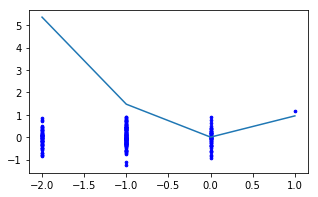

alpha= -0.150999737985  beta= -0.0949716746081 ANOVA pvalue= 7.306084791298619e-41


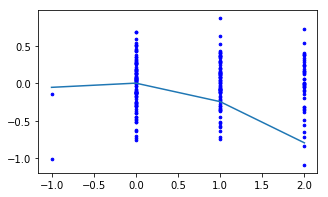

In [34]:
squadestrs = Goodexamples.head(2)
for index, item in squadestrs.iterrows():
    chrom = item["chrom"].split('r')[1]
    gene = item["gene"]
    start = item['str.start']
    tissue = "Lung"
    alpha = float(item['alpha'])
    beta = float(item['beta']) 
    print('alpha=', alpha, ' beta=', beta, 'ANOVA pvalue=', item['anova_pva'])
    ExtractData(gene, chrom, start, tissue)
    expr = pd.read_csv("expr.tab", names=["sample","expr"])
    strgt = pd.read_csv("str_genotypes.tab", sep="\t", names=["sample","str"])
    strgt['sample']=strgt['sample'].apply(lambda x: "-".join(x.split('-')[:2]))
    data = pd.merge(strgt, expr)
    plt.figure( figsize=(5,3))
    plt.scatter(data['str'], data['expr'], color='blue',marker='o', s=7)
    #fit a non-linear regression
    
    x = sorted([float(i) for i in list(data['str'])])
    plt.plot(x,[alpha*i**2 + beta*i for i in x])
    plt.show()
    #break

In [ ]:
#Interpretation Top eSTRs that are called in quadratic
"""alpha (squared term)  > 0 ==> Relationship is convex
                         < 0 ==> Relationship is concave 
"""
for index, item in squadestrs.iterrows():
    chrom = item["chrom"].split('r')[1]
    gene = item["gene"]  
    start = item['str.start']
    tissue = "Lung"
    genename = item['gene.name']
    motif = item['motif']
    print('\nAlpha = ', item['alpha'], " Beta = ",item['beta'])
    ExtractData(gene, chrom, start, tissue)
    PlotESTR(gene, tissue, chrom, start, COLORS, genename, motif)